activate conda environment sklearn.yml

## IMPORTS

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

from numpy.random import default_rng
rng = default_rng()

from pygel3d import hmesh

## FUNCTIONS

In [21]:
def hull_dist(hull, positions):
    m = hmesh.Manifold().from_triangles(hull.points, hull.simplices)
        
    dist = hmesh.MeshDistance(m)
    result = dist.signed_distance(positions)
    return(np.absolute(result))
    

In [22]:
def in_hull(hull, p):

    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [23]:
def sample_small_cluster(melpos, s, cr):
    covmel = np.cov(melpos.T)*cr
    meanmel = np.mean(melpos, axis=0)
    
    melsam = rng.multivariate_normal(meanmel, covmel, s)
    return(np.concatenate([melpos, melsam]))

In [24]:
def hull_plot(gampos, gamhull, ngampos):
    plt.scatter(gampos[:,0], gampos[:,2])
    plt.scatter(gampos[gamhull.vertices,0], gampos[gamhull.vertices,2])
    plt.scatter(ngampos[:,0], ngampos[:,2], alpha=.5)
    plt.show()

In [25]:
def remove_intersection(miscoords, hullverts):
    #Construct Delaunay triangulation of intersected hull
    Dhull = Delaunay(hullverts)
    
    #Find simplex containing the misclassified point
    s = Dhull.find_simplex(miscoords)
    
    svertices = Dhull.simplices[s]
    #Compute barycentric coordinates of misclassified point
    b = Dhull.transform[s,:3].dot(np.transpose(np.array([miscoords]) - Dhull.transform[s,3]))
    bccoords = np.c_[np.transpose(b), 1-b.sum(axis=0)][0]
    #Find closest simplex point
    print("barycentric coordinates are ", bccoords, " in simplex ", svertices)
    rem = svertices[bccoords==bccoords.max()]
    print("remove vertex ", rem, " corresponding to ", hullverts[rem], " from convex hull")
    return(rem, hullverts[rem])
    

### Import data
Combination of 1) reference data 2) additional ag1k samples 3) PCR confirmed fontenillei from Gabon

In [3]:
latentref = pd.read_csv("../../data/metadata/GCrefv1.tsv", sep='\t', usecols=[0,5,6,7,3])
latentval = pd.read_csv("../../data/metadata/ConvexHulls.tsv", sep='\t', usecols=[0,1,2,3,8])

In [60]:
latentref.head()

,sample_id,species,mean1,mean2,mean3
0,AN0453-C,Anopheles_gambiae,-98.92367,-29.281832,-5.297733
1,AA0137-C,Anopheles_gambiae,-86.95990,-13.467476,-13.105860
2,AZ0425-CW,Anopheles_coluzzii,-77.11659,3.552496,-21.382800
3,AZ0269-C,Anopheles_coluzzii,-95.77140,5.239405,-27.965204
4,BL0145-C,Anopheles_arabiensis,-82.95827,-74.466360,31.757212


In [61]:
latentval.head()

,sample_id,mean1,mean2,mean3,species
0,BL0115-C,-86.316620,-18.192635,-9.433698,Anopheles_gambiae
1,BL0379-C,-93.780304,-46.341760,8.987965,Anopheles_gambiae
2,BL0142-C,-93.042210,-24.190320,-7.162872,Anopheles_gambiae
3,AK0215-C,-111.094790,-54.899857,10.321958,Anopheles_gambiae
4,BP0019-C,-84.537200,-28.287815,-1.510494,Anopheles_gambiae


In [62]:
#drop pest because of unclear label
latentref = latentref.drop(637)
#set Kenyan intermediates to gambiae
latentref.loc[latentref.species=='Intermediate_gambiae_coluzzii', 'species'] = 'Anopheles_gambiae'

In [63]:
#combine
latent = pd.concat([latentref, latentval], ignore_index=True)
latent.head()

,sample_id,species,mean1,mean2,mean3
0,AN0453-C,Anopheles_gambiae,-98.92367,-29.281832,-5.297733
1,AA0137-C,Anopheles_gambiae,-86.95990,-13.467476,-13.105860
2,AZ0425-CW,Anopheles_coluzzii,-77.11659,3.552496,-21.382800
3,AZ0269-C,Anopheles_coluzzii,-95.77140,5.239405,-27.965204
4,BL0145-C,Anopheles_arabiensis,-82.95827,-74.466360,31.757212


In [64]:
#Merge bwambae and fontenillei
latent.loc[latent.species.isin(['Anopheles_bwambae', 'Anopheles_fontenillei']), 'species'] = 'Anopheles_bwambae_fontenillei'

In [65]:
latent.shape

(1144, 5)

In [66]:
latent.species.unique()

array(['Anopheles_gambiae', 'Anopheles_coluzzii', 'Anopheles_arabiensis',
       'Anopheles_melas', 'Anopheles_merus', 'Anopheles_tengrela',
       'Anopheles_bwambae_fontenillei', 'Anopheles_quadriannulatus'],
      dtype=object)

### Generate hulls and iteratively check overlaps

In [33]:
gampos = latent.loc[latent.species=='Anopheles_gambiae', ['mean1', 'mean2', 'mean3']].values

#Create gambiae hull
gamhull = ConvexHull(gampos)


In [34]:
colpos = latent.loc[latent.species=='Anopheles_coluzzii', ['mean1', 'mean2', 'mean3']].values

colhull = ConvexHull(colpos)


In [35]:
arapos = latent.loc[latent.species=='Anopheles_arabiensis', ['mean1', 'mean2', 'mean3']].values

arahull = ConvexHull(arapos)


In [36]:
tenpos = latent.loc[latent.species=='Anopheles_tengrela', ['mean1', 'mean2', 'mean3']].values

tenhull = ConvexHull(tenpos)


In [37]:
quadpos = latent.loc[latent.species=='Anopheles_quadriannulatus', ['mean1', 'mean2', 'mean3']].values

quadhull = ConvexHull(quadpos)


In [38]:
merpos = latent.loc[latent.species=='Anopheles_merus', ['mean1', 'mean2', 'mean3']].values

merhull = ConvexHull(merpos)


In [39]:
melpos = latent.loc[latent.species=='Anopheles_melas', ['mean1', 'mean2', 'mean3']].values
nmelpos = latent.loc[latent.species!='Anopheles_melas', ['mean1', 'mean2', 'mean3']].values

#too few points to construct a convex hull
melpos = sample_small_cluster(melpos, 3, 1)

melhull = ConvexHull(melpos)


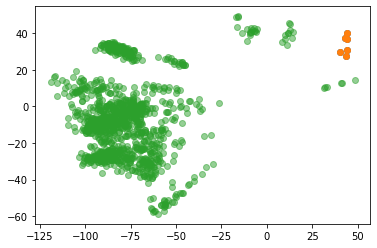

In [40]:
hull_plot(melpos, melhull, nmelpos)

In [41]:
bwapos = latent.loc[latent.species=='Anopheles_bwambae_fontenillei', ['mean1', 'mean2', 'mean3']].values

bwahull = ConvexHull(bwapos)


### Check overlap new points

In [42]:
npos = np.concatenate([colpos, arapos, tenpos, quadpos, merpos, melpos, bwapos])
in_hull(gampos[gamhull.vertices], npos).any()

True

In [43]:
npos = np.concatenate([gampos, arapos, tenpos, quadpos, merpos, melpos, bwapos])
in_hull(colpos[colhull.vertices], npos).any()

True

In [44]:
npos = np.concatenate([gampos, colpos, tenpos, quadpos, merpos, melpos, bwapos])
in_hull(arapos[arahull.vertices], npos).any()

False

In [45]:
npos = np.concatenate([gampos, colpos, arapos, quadpos, merpos, melpos, bwapos])
in_hull(tenpos[tenhull.vertices], npos).any()

False

In [46]:
npos = np.concatenate([gampos, colpos, arapos, tenpos, merpos, melpos, bwapos])
in_hull(quadpos[quadhull.vertices], npos).any()

False

In [47]:
npos = np.concatenate([gampos, colpos, arapos, tenpos, quadpos, melpos, bwapos])
in_hull(merpos[merhull.vertices], npos).any()

False

In [48]:
npos = np.concatenate([gampos, colpos, arapos, tenpos, quadpos, merpos, bwapos])
in_hull(melpos[melhull.vertices], npos).any()

False

In [49]:
npos = np.concatenate([gampos, colpos, arapos, tenpos, quadpos, merpos,  melpos])
in_hull(bwapos[bwahull.vertices], npos).any()

False

### Trim hulls 
Only gambiae and coluzzii have overlap

In [50]:
#Coluzzii samples in gambiae hull
latent.loc[(in_hull(gamhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_gambiae')]

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
885,-89.73308,-4.175175,-19.968115,-50.549084,-34.890660,-25.002098,AG0054-C,NaN,Anopheles_coluzzii,"Gambia, The",61.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
#Gambiae samples in coluzzii hull
latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')]

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
192,-73.29465,-2.589964,-16.276306,-42.570786,-29.508860,-20.843548,AJ0038-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,-80.41046,-3.088692,-18.063430,-45.966305,-31.718494,-22.806133,AG0109-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398,-67.50247,0.318223,-16.347507,-40.721775,-27.654715,-19.569480,AG0133-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543,-90.08236,-3.409421,-20.672806,-51.111150,-35.031060,-25.239360,AG0223-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,-67.56894,3.975850,-18.803062,-42.002518,-27.333405,-19.980871,AJ0107-C,NaN,Anopheles_gambiae,Guinea-Bissau,61.0,AG1000G-GW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,-84.46269,0.006021,-21.360750,-49.235558,-32.851147,-24.142105,AG0202-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1049,-79.59563,2.168072,-21.256016,-47.632057,-31.186900,-22.960567,AG0082-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1073,-86.07066,-2.614085,-20.073202,-49.332900,-33.666367,-24.377731,AG0085-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1103,-72.78046,2.068372,-19.226270,-43.857403,-28.948132,-20.986980,AZ0484-CW,NaN,Anopheles_gambiae,Mali,57.0,AG1000G-ML-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So these are the problematic points. Will remove all those points as well as for each of them the 'responsible' point of the other hull.

In [52]:
#While the two points identified are in the gambiae convex hull
gamremvert = []
while latent.loc[(in_hull(gamhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_gambiae')].shape[0] ==2:
    display(latent.loc[(in_hull(gamhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_gambiae')])
    gamrem = []
    for idx in [885, 958]:
        rem, vert = remove_intersection(latent.loc[idx, ['mean1', 'mean2', 'mean3']], gamhull.points[gamhull.vertices])
        gamrem.append(gamhull.vertices[rem][0])
        gamremvert.append(vert)
    print(gamrem, gamhull.points.shape)
    gampos = np.delete(gamhull.points, gamrem, axis=0)
    gamhull = ConvexHull(gampos)
    print(gamhull.points.shape)

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
885,-89.73308,-4.175175,-19.968115,-50.549084,-34.890660,-25.002098,AG0054-C,NaN,Anopheles_coluzzii,"Gambia, The",61.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.1570797913743276 0.17961599576667986 0.1102900707125476
 0.553014142146445]  in simplex  [ 1 32 37  3]
remove vertex  [3]  corresponding to  [[-95.13781   -3.671883 -21.827198]]  from convex hull
barycentric coordinates are  [0.31780048547608475 0.5487776780632956 0.13108923485490465
 0.0023326016057150234]  in simplex  [ 1  0 37 29]
remove vertex  [0]  corresponding to  [[-64.63394      0.11119624 -15.61555   ]]  from convex hull
[63, 9] (606, 3)
(604, 3)


In [53]:
grv = np.zeros((len(gamremvert), 3))
for e,g in enumerate(gamremvert):
    grv[e,:] = g[0]
#grv

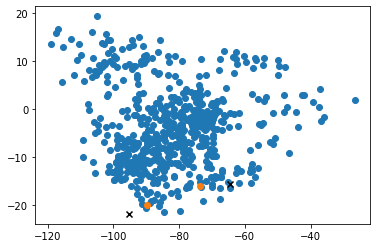

In [54]:
plt.scatter(gamhull.points[:,0], gamhull.points[:,2])
plt.scatter(latent.loc[[885, 958], 'mean1'], latent.loc[[885, 958], 'mean3'])
plt.scatter(grv[:,0], grv[:,2], marker='x', c='k')
plt.show()

In [55]:
#Which points are left?
latent.loc[(in_hull(gamhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_gambiae')]

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
#While the one point identified is in the gambiae convex hull
while latent.loc[(in_hull(gamhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_gambiae')].shape[0] ==1:
    display(latent.loc[(in_hull(gamhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_gambiae')])
    gamrem = []
    for idx in [958]:
        rem, vert = remove_intersection(latent.loc[idx, ['mean1', 'mean2', 'mean3']], gamhull.points[gamhull.vertices])
        gamrem.append(gamhull.vertices[rem][0])
        gamremvert.append(vert)
    print(gamrem, gamhull.points.shape)
    gampos = np.delete(gamhull.points, gamrem, axis=0)
    gamhull = ConvexHull(gampos)
    print(gamhull.points.shape)

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.44900439509082446 0.34490171498251243 0.14318159778459005
 0.06291229214207306]  in simplex  [31 34  1 19]
remove vertex  [31]  corresponding to  [[-85.79378   -3.589487 -19.438797]]  from convex hull
[513] (604, 3)
(603, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.4592088790528095 0.32392919328707137 0.20868665849563683
 0.008175269164482302]  in simplex  [33  0  1 19]
remove vertex  [33]  corresponding to  [[-72.78046     2.0683722 -19.22627  ]]  from convex hull
[585] (603, 3)
(602, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.331509258539441 0.30658643726305 0.2209923059481298 0.14091199824937917]  in simplex  [27 33  0  1]
remove vertex  [27]  corresponding to  [[-58.21181     2.8659923 -15.3480835]]  from convex hull
[491] (602, 3)
(601, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.20075341576018246 0.5227413921859814 0.06162715480073899
 0.21487803725309718]  in simplex  [11 32  0  1]
remove vertex  [32]  corresponding to  [[-89.00952    -4.9584117 -19.47616  ]]  from convex hull
[592] (601, 3)
(600, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.2918227155031552 0.2993524311003668 0.11243140040301114
 0.29639345299346687]  in simplex  [ 0  1 25 26]
remove vertex  [1]  corresponding to  [[-46.519142  -1.459179  -9.11595 ]]  from convex hull
[54] (600, 3)
(599, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.36546401699683884 0.4683434491444487 0.06316084230698493
 0.10303169155172753]  in simplex  [ 0 24 25 15]
remove vertex  [24]  corresponding to  [[-67.56894     3.9758499 -18.803062 ]]  from convex hull
[448] (599, 3)
(598, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.25980540769334226 0.29032466697091763 0.3636334858564112
 0.08623643947932891]  in simplex  [ 0 10 24 15]
remove vertex  [24]  corresponding to  [[-8.4462690e+01  6.0211066e-03 -2.1360750e+01]]  from convex hull
[466] (598, 3)
(597, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.5277496359873837 0.12010459430496923 0.255029342519272
 0.0971164271883751]  in simplex  [29  0 10 15]
remove vertex  [29]  corresponding to  [[-86.07066    -2.6140854 -20.073202 ]]  from convex hull
[561] (597, 3)
(596, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.5715581449580043 0.22537457659682758 0.10209093821773507
 0.10097634022743307]  in simplex  [ 2 11 29 16]
remove vertex  [2]  corresponding to  [[-87.569214  -4.977799 -18.9535  ]]  from convex hull
[124] (596, 3)
(595, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.30263131001777843 0.1880381644393836 0.4020206431751845
 0.10730988236765349]  in simplex  [ 0 10 28 15]
remove vertex  [28]  corresponding to  [[-79.59563     2.1680717 -21.256016 ]]  from convex hull
[543] (595, 3)
(594, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.4055255245756788 0.014068914176095904 0.05943565070686052
 0.5209699105413648]  in simplex  [7 9 0 1]
remove vertex  [1]  corresponding to  [[-67.34634    -3.3452482 -14.0980215]]  from convex hull
[21] (594, 3)
(593, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.3870989457399219 0.26503776353479225 0.2762011988332347
 0.0716620918920512]  in simplex  [ 6  8  3 19]
remove vertex  [6]  corresponding to  [[-80.41046   -3.088692 -18.06343 ]]  from convex hull
[160] (593, 3)
(592, 3)


,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
958,-73.68822,-3.233275,-15.992825,-42.061108,-29.316452,-20.868866,AG0014-C,NaN,Anopheles_coluzzii,"Gambia, The",59.0,AG1000G-GM-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.17663865391010347 0.0003452293737620238 0.79705419608932
 0.02596192062681446]  in simplex  [ 3 20  4 19]
remove vertex  [4]  corresponding to  [[-73.29465    -2.5899637 -16.276306 ]]  from convex hull
[103] (592, 3)
(591, 3)


In [57]:
grv = np.zeros((len(gamremvert), 3))
for e,g in enumerate(gamremvert):
    grv[e,:] = g[0]
#grv

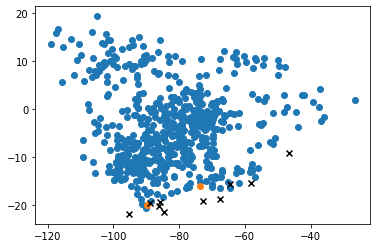

In [58]:
plt.scatter(gamhull.points[:,0], gamhull.points[:,2])
plt.scatter(latent.loc[[885, 958], 'mean1'], latent.loc[[885, 958], 'mean3'])
plt.scatter(grv[:10,0], grv[:10,2], marker='x', c='k')
plt.show()

In [59]:
#Any points left?
latent.loc[(in_hull(gamhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_gambiae')]

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate


In [60]:
#gambiae points in coluzzii hull
latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')]

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
192,-73.29465,-2.589964,-16.276306,-42.570786,-29.508860,-20.843548,AJ0038-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,-80.41046,-3.088692,-18.063430,-45.966305,-31.718494,-22.806133,AG0109-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398,-67.50247,0.318223,-16.347507,-40.721775,-27.654715,-19.569480,AG0133-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543,-90.08236,-3.409421,-20.672806,-51.111150,-35.031060,-25.239360,AG0223-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,-67.56894,3.975850,-18.803062,-42.002518,-27.333405,-19.980871,AJ0107-C,NaN,Anopheles_gambiae,Guinea-Bissau,61.0,AG1000G-GW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,-84.46269,0.006021,-21.360750,-49.235558,-32.851147,-24.142105,AG0202-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1049,-79.59563,2.168072,-21.256016,-47.632057,-31.186900,-22.960567,AG0082-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1073,-86.07066,-2.614085,-20.073202,-49.332900,-33.666367,-24.377731,AG0085-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1103,-72.78046,2.068372,-19.226270,-43.857403,-28.948132,-20.986980,AZ0484-CW,NaN,Anopheles_gambiae,Mali,57.0,AG1000G-ML-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
#While the nine points identified are in the coluzzii convex hull
colremvert = []
while latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')].shape[0] ==9:
    display(latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')])
    colrem = []
    for idx in [192, 307, 398, 543, 862, 895, 1049, 1073, 1103]:
        rem, vert = remove_intersection(latent.loc[idx, ['mean1', 'mean2', 'mean3']], colhull.points[colhull.vertices])
        colrem.append(colhull.vertices[rem][0])
        colremvert.append(vert)
    print(colrem, colhull.points.shape)
    colpos = np.delete(colhull.points, colrem, axis=0)
    colhull = ConvexHull(colpos)
    print(colhull.points.shape)

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
192,-73.29465,-2.589964,-16.276306,-42.570786,-29.508860,-20.843548,AJ0038-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,-80.41046,-3.088692,-18.063430,-45.966305,-31.718494,-22.806133,AG0109-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398,-67.50247,0.318223,-16.347507,-40.721775,-27.654715,-19.569480,AG0133-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543,-90.08236,-3.409421,-20.672806,-51.111150,-35.031060,-25.239360,AG0223-C,training,Anopheles_gambiae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,-67.56894,3.975850,-18.803062,-42.002518,-27.333405,-19.980871,AJ0107-C,NaN,Anopheles_gambiae,Guinea-Bissau,61.0,AG1000G-GW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,-84.46269,0.006021,-21.360750,-49.235558,-32.851147,-24.142105,AG0202-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1049,-79.59563,2.168072,-21.256016,-47.632057,-31.186900,-22.960567,AG0082-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1073,-86.07066,-2.614085,-20.073202,-49.332900,-33.666367,-24.377731,AG0085-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1103,-72.78046,2.068372,-19.226270,-43.857403,-28.948132,-20.986980,AZ0484-CW,NaN,Anopheles_gambiae,Mali,57.0,AG1000G-ML-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.9476579449779512 0.0003204159132910167 0.009373588955226553
 0.042648050153531236]  in simplex  [21 19 13 12]
remove vertex  [21]  corresponding to  [[-73.68822    -3.2332747 -15.992825 ]]  from convex hull
barycentric coordinates are  [0.024669879154898322 0.2222051775709062 0.6301772642127688
 0.12294767906142678]  in simplex  [ 6 20 21 14]
remove vertex  [21]  corresponding to  [[-73.68822    -3.2332747 -15.992825 ]]  from convex hull
barycentric coordinates are  [0.27436283653869253 0.08121423720790233 0.6332627807420615
 0.011160145511343589]  in simplex  [ 7 16 21 19]
remove vertex  [21]  corresponding to  [[-73.68822    -3.2332747 -15.992825 ]]  from convex hull
barycentric coordinates are  [0.03897396409375513 0.4285956222468563 0.14830750647896718
 0.3841229071804213]  in simplex  [ 6 20 21 14]
remove vertex  [20]  corresponding to  [[-89.73308   -4.175175 -19.968115]]  from convex hull
barycentric coordinates are  [0.4686565549975507 0.07202393

In [62]:
crv = np.zeros((len(colremvert), 3))
for e,g in enumerate(colremvert):
    crv[e,:] = g[0]
#crv

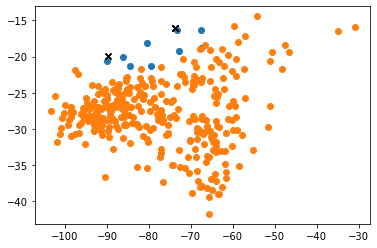

In [63]:
plt.scatter(latent.loc[[192, 307, 398, 543, 862, 895, 1049, 1073, 1103],'mean1'], latent.loc[[192, 307, 398, 543, 862, 895, 1049, 1073, 1103],'mean3'])
plt.scatter(colhull.points[:,0], colhull.points[:,2])
plt.scatter(crv[:,0], crv[:,2], marker='x', c='k')
plt.show()

In [64]:
#Which points are left?
latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')]

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
862,-67.56894,3.975850,-18.803062,-42.002518,-27.333405,-19.980871,AJ0107-C,NaN,Anopheles_gambiae,Guinea-Bissau,61.0,AG1000G-GW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,-84.46269,0.006021,-21.360750,-49.235558,-32.851147,-24.142105,AG0202-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1049,-79.59563,2.168072,-21.256016,-47.632057,-31.186900,-22.960567,AG0082-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
while latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')].shape[0] ==3:
    display(latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')])
    colrem = []
    for idx in [862, 895, 1049]:
        rem, vert = remove_intersection(latent.loc[idx, ['mean1', 'mean2', 'mean3']], colhull.points[colhull.vertices])
        colrem.append(colhull.vertices[rem][0])
        colremvert.append(vert)
    print(colrem, colhull.points.shape)
    colpos = np.delete(colhull.points, colrem, axis=0)
    colhull = ConvexHull(colpos)
    print(colhull.points.shape)

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
862,-67.56894,3.975850,-18.803062,-42.002518,-27.333405,-19.980871,AJ0107-C,NaN,Anopheles_gambiae,Guinea-Bissau,61.0,AG1000G-GW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,-84.46269,0.006021,-21.360750,-49.235558,-32.851147,-24.142105,AG0202-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1049,-79.59563,2.168072,-21.256016,-47.632057,-31.186900,-22.960567,AG0082-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.506894795289949 0.1130595802360157 0.1263048906362334
 0.25374073383780194]  in simplex  [16 19 12 14]
remove vertex  [16]  corresponding to  [[-54.244953    3.7299707 -14.429712 ]]  from convex hull
barycentric coordinates are  [0.06869935196600974 0.13128044140971684 0.10195171514377732
 0.6980684914804961]  in simplex  [ 5 16 19 14]
remove vertex  [14]  corresponding to  [[-97.543945  -4.979124 -21.7884  ]]  from convex hull
barycentric coordinates are  [0.16640967552769131 0.12259925280258327 0.19294167913439508
 0.5180493925353303]  in simplex  [16 19 12 14]
remove vertex  [14]  corresponding to  [[-97.543945  -4.979124 -21.7884  ]]  from convex hull
[214, 199, 199] (316, 3)
(314, 3)


In [66]:
crv = np.zeros((len(colremvert), 3))
for e,g in enumerate(colremvert):
    crv[e,:] = g[0]
#crv

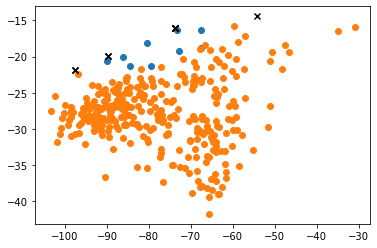

In [67]:
plt.scatter(latent.loc[[192, 307, 398, 543, 862, 895, 1049, 1073, 1103],'mean1'], latent.loc[[192, 307, 398, 543, 862, 895, 1049, 1073, 1103],'mean3'])
plt.scatter(colhull.points[:,0], colhull.points[:,2])
plt.scatter(crv[:,0], crv[:,2], marker='x', c='k')
plt.show()

In [68]:
#Which points are left?
latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')]

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
862,-67.56894,3.975850,-18.803062,-42.002518,-27.333405,-19.980871,AJ0107-C,NaN,Anopheles_gambiae,Guinea-Bissau,61.0,AG1000G-GW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1049,-79.59563,2.168072,-21.256016,-47.632057,-31.186900,-22.960567,AG0082-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
while latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')].shape[0] ==2:
    display(latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')])
    colrem = []
    for idx in [862, 1049]:
        rem, vert = remove_intersection(latent.loc[idx, ['mean1', 'mean2', 'mean3']], colhull.points[colhull.vertices])
        colrem.append(colhull.vertices[rem][0])
        colremvert.append(vert)
    print(colrem, colhull.points.shape)
    colpos = np.delete(colhull.points, colrem, axis=0)
    colhull = ConvexHull(colpos)
    print(colhull.points.shape)

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate
862,-67.56894,3.975850,-18.803062,-42.002518,-27.333405,-19.980871,AJ0107-C,NaN,Anopheles_gambiae,Guinea-Bissau,61.0,AG1000G-GW,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1049,-79.59563,2.168072,-21.256016,-47.632057,-31.186900,-22.960567,AG0082-C,NaN,Anopheles_gambiae,"Gambia, The",62.0,AG1000G-GM-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN


barycentric coordinates are  [0.7114659660685306 0.0777425970899619 0.07306749399941426
 0.13772394284209322]  in simplex  [ 8 18 14 19]
remove vertex  [8]  corresponding to  [[-59.69787     3.1771915 -15.780422 ]]  from convex hull
barycentric coordinates are  [0.37518284571148164 0.09071046945496408 0.0899908823953548
 0.4441158024381995]  in simplex  [ 8 18 14 19]
remove vertex  [19]  corresponding to  [[-97.00882    -3.7788432 -22.439726 ]]  from convex hull
[144, 246] (314, 3)
(312, 3)


In [70]:
crv = np.zeros((len(colremvert), 3))
for e,g in enumerate(colremvert):
    crv[e,:] = g[0]

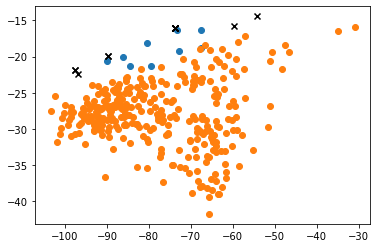

In [71]:
plt.scatter(latent.loc[[192, 307, 398, 543, 862, 895, 1049, 1073, 1103],'mean1'], latent.loc[[192, 307, 398, 543, 862, 895, 1049, 1073, 1103],'mean3'])
plt.scatter(colhull.points[:,0], colhull.points[:,2])
plt.scatter(crv[:,0], crv[:,2], marker='x', c='k')
plt.show()

In [72]:
#Which points are left?
latent.loc[(in_hull(colhull.points, latent[['mean1', 'mean2', 'mean3']])) & (latent.species != 'Anopheles_coluzzii')]

,mean1,mean2,mean3,sd1,sd2,sd3,sample_id,status,species,country,n_mosquito_targets,sample_set,Unnamed: 0,year,latitude,longitude,amplified,sex,plate


In [73]:
#Now we have to check which of the initially mislabelled points are still in the hulls and remove those. 
#For coluzzii
#These were the first ones to be removed
display(latent.loc[[885, 958], ['mean1', 'mean2', 'mean3']])
print(crv)

,mean1,mean2,mean3
885,-89.73308,-4.175175,-19.968115
958,-73.68822,-3.233275,-15.992825


[[-73.68822    -3.2332747 -15.992825 ]
 [-73.68822    -3.2332747 -15.992825 ]
 [-73.68822    -3.2332747 -15.992825 ]
 [-89.73308    -4.175175  -19.968115 ]
 [-73.68822    -3.2332747 -15.992825 ]
 [-89.73308    -4.175175  -19.968115 ]
 [-73.68822    -3.2332747 -15.992825 ]
 [-73.68822    -3.2332747 -15.992825 ]
 [-73.68822    -3.2332747 -15.992825 ]
 [-54.244953    3.7299707 -14.429712 ]
 [-97.543945   -4.979124  -21.7884   ]
 [-97.543945   -4.979124  -21.7884   ]
 [-59.69787     3.1771915 -15.780422 ]
 [-97.00882    -3.7788432 -22.439726 ]]


In [74]:
#For gambiae
display(latent.loc[[192, 307, 398, 543, 862, 895, 1049, 1073, 1103], ['mean1', 'mean2', 'mean3']])
print(grv)
#192,307,862,895,1049,1073,1103 already removed
#to remove 398,543

,mean1,mean2,mean3
192,-73.29465,-2.589964,-16.276306
307,-80.41046,-3.088692,-18.063430
398,-67.50247,0.318223,-16.347507
543,-90.08236,-3.409421,-20.672806
862,-67.56894,3.975850,-18.803062
895,-84.46269,0.006021,-21.360750
1049,-79.59563,2.168072,-21.256016
1073,-86.07066,-2.614085,-20.073202
1103,-72.78046,2.068372,-19.226270


[[-9.51378100e+01 -3.67188300e+00 -2.18271980e+01]
 [-6.46339400e+01  1.11196240e-01 -1.56155500e+01]
 [-8.57937800e+01 -3.58948700e+00 -1.94387970e+01]
 [-7.27804600e+01  2.06837220e+00 -1.92262700e+01]
 [-5.82118100e+01  2.86599230e+00 -1.53480835e+01]
 [-8.90095200e+01 -4.95841170e+00 -1.94761600e+01]
 [-4.65191420e+01 -1.45917900e+00 -9.11595000e+00]
 [-6.75689400e+01  3.97584990e+00 -1.88030620e+01]
 [-8.44626900e+01  6.02110660e-03 -2.13607500e+01]
 [-8.60706600e+01 -2.61408540e+00 -2.00732020e+01]
 [-8.75692140e+01 -4.97779900e+00 -1.89535000e+01]
 [-7.95956300e+01  2.16807170e+00 -2.12560160e+01]
 [-6.73463400e+01 -3.34524820e+00 -1.40980215e+01]
 [-8.04104600e+01 -3.08869200e+00 -1.80634300e+01]
 [-7.32946500e+01 -2.58996370e+00 -1.62763060e+01]]


In [75]:
gampos = gampos[(np.sum(np.abs(gampos-latent.loc[398, ['mean1', 'mean2', 'mean3']].values), axis=1)>0.001) & 
       (np.sum(np.abs(gampos-latent.loc[543, ['mean1', 'mean2', 'mean3']].values), axis=1)>0.001),:]

In [76]:
gamhull = ConvexHull(gampos)

### Save hullpoints

In [77]:
hulls = pd.DataFrame(gamhull.points[gamhull.vertices,:], columns=['mean1','mean2','mean3'])
hulls['species']='Anopheles_gambiae'

In [78]:
df = pd.DataFrame(colhull.points[colhull.vertices,:], columns=['mean1','mean2','mean3'])
df['species']='Anopheles_coluzzii'
hulls = pd.concat([hulls,df], ignore_index=True)

In [79]:
df = pd.DataFrame(arahull.points[arahull.vertices,:], columns=['mean1','mean2','mean3'])
df['species']='Anopheles_arabiensis'
hulls = pd.concat([hulls,df], ignore_index=True)

In [80]:
df = pd.DataFrame(tenhull.points[tenhull.vertices,:], columns=['mean1','mean2','mean3'])
df['species']='Anopheles_tengrela'
hulls = pd.concat([hulls,df], ignore_index=True)

In [81]:
df = pd.DataFrame(melhull.points[melhull.vertices,:], columns=['mean1','mean2','mean3'])
df['species']='Anopheles_melas'
hulls = pd.concat([hulls,df], ignore_index=True)

In [82]:
df = pd.DataFrame(merhull.points[merhull.vertices,:], columns=['mean1','mean2','mean3'])
df['species']='Anopheles_merus'
hulls = pd.concat([hulls,df], ignore_index=True)

In [83]:
df = pd.DataFrame(quadhull.points[quadhull.vertices,:], columns=['mean1','mean2','mean3'])
df['species']='Anopheles_quadriannulatus'
hulls = pd.concat([hulls,df], ignore_index=True)

In [84]:
df = pd.DataFrame(bwahull.points[bwahull.vertices,:], columns=['mean1','mean2','mean3'])
df['species']='Anopheles_bwambae_fontenillei'
hulls = pd.concat([hulls,df], ignore_index=True)

In [85]:
hulls.to_csv('convex_hulls_v1.csv', index=False)

In [96]:
hull_dist(gamhull, colpos).min()

2.8679028

In [97]:
hull_dist(colhull, gampos).min()

2.8645868

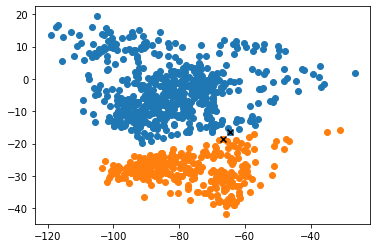

In [104]:
plt.scatter(gampos[:,0], gampos[:,2])
plt.scatter(colpos[:,0], colpos[:,2])
cmin = colpos[hull_dist(gamhull, colpos)==hull_dist(gamhull, colpos).min(),:]
plt.scatter(cmin[0,0], cmin[0,2], marker='x', c='k')
gmin = gampos[hull_dist(colhull, gampos)==hull_dist(colhull, gampos).min(),:]
plt.scatter(gmin[0,0], gmin[0,2], marker='x', c='k')
plt.show()